In [2]:
import sys
sys.path.insert(0, '../')
import motorshed
from bokeh.io import export_png, export_svgs

import pickle
import random
import numpy as np
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import matplotlib.cm as cm

%matplotlib inline

In [ ]:
import os
os

In [7]:
from importlib import reload
reload(motorshed)

<module 'motorshed' from '../motorshed.py'>

# Using Tavi's code, this works

In [4]:
addresses = ['1807 Page Street, San Francisco, CA',
             '2010 Filbert Street, Oakland CA',
             '42 Olive Avenue, Larkspur, CA']

center_nodes = [motorshed.get_map(address, distance=200)[1] for address in addresses]
address_origins = [motorshed.get_map(address, distance=200)[2] for address in addresses]

center = np.array(address_origins).mean(axis=0)
origin_point = tuple(center)

In [5]:
# Tyler's map
# address = 'Avenue of the Palms, San Francisco, CA 94130'
distance = 20000 # 20000

G, center_node, origin_point = motorshed.get_map(origin_point, distance=distance)

In [8]:
%%time
for address in addresses:
    address_origin = motorshed.get_map(address, distance=200)[2]
    motorshed.get_transit_times(G, address_origin, local_host=True)
    
    for node in G.nodes():
        G.nodes[node][address] = G.nodes[node]['transit_time']
        
for node,data in G.nodes(data=True):
    G.nodes[node]['transit_time'] = min([data[address] for address in addresses])

359it [03:28,  1.72it/s]                         
359it [03:24,  1.76it/s]                         
359it [04:56,  1.21it/s]                         


CPU times: user 52 s, sys: 9.49 s, total: 1min 1s
Wall time: 12min 12s


In [9]:
fn = 'Tyler/Tyler.timed.pkl'

with open(fn, 'wb') as f:
    pickle.dump((G, center_nodes), f)

In [10]:
%%time
px = 1000

p = motorshed.make_bokeh_map(G, center_nodes, color_by='transit_time', 
                             plot_width=px, plot_height=px)

CPU times: user 37.5 s, sys: 4.41 s, total: 41.9 s
Wall time: 1min 44s


In [11]:
%%time
export_png(p, filename='Tyler/Tyler-New-by-time.png')

CPU times: user 14.6 s, sys: 3.17 s, total: 17.8 s
Wall time: 5min 44s


'/Users/octavisemonin/Dropbox/motorshed-branch/notebooks/Tyler/Tyler-New-by-time.png'

In [12]:
len(G.nodes)

107593

In [13]:
missing_edges, missing_nodes = motorshed.find_all_routes(G, center_nodes, local_host=True, 
                                                         start_far_away=True, show_progress=False)

100%|██████████| 107593/107593 [2:59:44<00:00,  9.98it/s]  


Analyzed all nodes without reaching max requests.


In [14]:
fn = 'Tyler/Tyler.routed.pkl'

with open(fn, 'wb') as f:
    pickle.dump((G, center_nodes), f)

In [28]:
from importlib import reload
reload(motorshed)

<module 'motorshed' from '../motorshed.py'>

In [29]:
%%time
px = 4000

p = motorshed.make_bokeh_map(G, center_nodes, color_by='through_traffic', max_width=12.0,
                             plot_width=px, plot_height=px, palette_name='viridis')

CPU times: user 25.4 s, sys: 4.23 s, total: 29.6 s
Wall time: 1min 8s


In [30]:
%%time
export_png(p, filename='Tyler/Tyler-New.png')

CPU times: user 8.38 s, sys: 772 ms, total: 9.15 s
Wall time: 1min 26s


'/Users/octavisemonin/Dropbox/motorshed-branch/notebooks/Tyler/Tyler-New.png'

# Make a website?

In [38]:
%%time
from bokeh.resources import CDN
from bokeh.embed import file_html

fn = 'Tyler-New'
html = file_html(p, CDN, fn)
with open(fn+'.html', 'w') as f:
    f.write(html)

CPU times: user 6.01 s, sys: 388 ms, total: 6.4 s
Wall time: 10.6 s


In [19]:
G.nodes[random.sample(G.nodes, 1)[0]]

{'y': 4193029.9770124876,
 'x': 564532.4772506135,
 'osmid': 53075885,
 'highway': 'stop',
 'ref': nan,
 'lon': -122.2661581,
 'lat': 37.8824813,
 'calculated': True,
 'transit_time': 863.6,
 '1807 Page Street, San Francisco, CA': 1786.2,
 '2010 Filbert Street, Oakland CA': 863.6,
 '42 Olive Avenue, Larkspur, CA': 2094.1}

In [22]:
G.edges[random.sample(G.edges, 1)[0]]

{'osmid': [8927184, 417087621, 397156566, 397156567],
 'lanes': ['5', '4'],
 'name': 'Guadalupe Canyon Parkway',
 'highway': 'tertiary',
 'oneway': False,
 'length': 1803.7430000000004,
 'geometry': <shapely.geometry.linestring.LineString at 0x124675d30>,
 'through_traffic': 98,
 'transit_time': 2481.25,
 'color': '#952C80',
 'width': 1.1805223780386984}

In [65]:
len(G.edges)

314277

In [90]:
%%time

edge_widths = np.array([data['width'] for u, v, data in G.edges(data=True)])
# dead_edges = edge_widths[edge_widths==0].tolist()

CPU times: user 336 ms, sys: 20.6 ms, total: 356 ms
Wall time: 356 ms


In [91]:
%%time

dead_edges = []

for i0, i1, key, data in G.edges(data=True, keys=True):
    if data['width'] == edge_widths.min():
        dead_edges.append((i0,i1,key))

G_sample = G.copy()
G_sample.remove_edges_from(dead_edges)

CPU times: user 58 s, sys: 653 ms, total: 58.6 s
Wall time: 58.9 s


In [92]:
len(G_sample.edges)

119877

In [ ]:
%%time

p = motorshed.make_bokeh_map(G_sample, nodes, color_by=None)

export_png(p, filename='Tyler-Total-Trimmed.png')

In [95]:
%%time

p = motorshed.make_bokeh_map(G, nodes, color_by=None)

export_png(p, filename='Tyler-Total-All.png')

CPU times: user 28 s, sys: 4.54 s, total: 32.6 s
Wall time: 47min 25s


# Timing:
Saving (to PNG) takes 30 minutes, everything else takes about 20 seconds. SVG takes only 10 minutes.

In [15]:
import pandas as pd
from bokeh.io import export_png, export_svgs
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Magma256,Viridis256,Greys256,Cividis256,Inferno256,Plasma256

In [16]:
%%time

lines = []
for u, v, k, data in G.edges(keys=True, data=True):
    through_traffic = data['through_traffic']
    width = data['width']
    color = data['color']
    if 'geometry' in data:
        xs, ys = data['geometry'].xy
    else:
        # if it doesn't have a geometry attribute, the edge is a straight
        # line from node to node
        xs = (G.nodes[u]['x'], G.nodes[v]['x'])
        ys = (G.nodes[u]['y'], G.nodes[v]['y'])

    line = {'xs': tuple(xs), 'ys': tuple(ys),
            'u': u, 'v': v, 
            'color': color, 'width': width, 
            'through_traffic': through_traffic,
            # 'name': data.get('name', ''),
            # 'oneway': data.get('oneway', ''),
            # 'highway': data.get('highway', ''),
            # 'data': str(data.keys())
            }
    lines.append(line)

CPU times: user 12.9 s, sys: 2.31 s, total: 15.3 s
Wall time: 17.1 s


In [17]:
%%time

df = pd.DataFrame(lines)
df = df.sort_values('width')
source = ColumnDataSource(df)


CPU times: user 2.57 s, sys: 63.3 ms, total: 2.63 s
Wall time: 2.64 s


In [18]:
%%time

plot_width=1000
plot_height=1000
toolbar_location=None
output_backend='svg'

p = figure(plot_width=plot_width, plot_height=plot_height, match_aspect=True, 
           output_backend=output_backend, toolbar_location=toolbar_location)

p.outline_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False
p.xgrid.visible = False
p.ygrid.visible = False
p.background_fill_color = "black" #None
p.border_fill_color = None


CPU times: user 8.14 ms, sys: 2.25 ms, total: 10.4 ms
Wall time: 10.1 ms


In [19]:
%%time

p.multi_line('xs', 'ys', source=source, color='color', line_width='width',
            line_join='round', line_cap='round')

CPU times: user 2.25 ms, sys: 394 µs, total: 2.64 ms
Wall time: 2.54 ms


bokeh.models.renderers.GlyphRenderer(
    id='0136c671-7aff-4d97-a90f-e93e88fe801c',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='9c3dc4f6-309f-4405-b866-d1eefeec8618',
        callback=None,
        data={'color': ['#1f312c',
          '#24401c',
          '#24411c',
          '#352920',
          '#24421d',
          '#24421d',
          '#24421d',
          '#253d2a',
          '#25421d',
          '#25431d',
          '#24401c',
          '#25421d',
          '#294520',
          '#24411d',
          '#24411c',
          '#25431d',
          '#24411d',
          '#24411d',
          '#24421d',
          '#24401c',
          '#24421d',
          '#24421d',
          '#24401c',
          '#25431d',
          '#25431d',
          '#24421d',
          '#24411d',
          '#25431d',
          '#24421d',
          '#24411d',
          '#25431d',
          '#253c29',
          '#24421d',
          '#24421d',
          '#25431d',
          '#25421d',
          '#25441d',
          '#25441d',
          '#25441d',
          '#25441d',
          '#25441d',
          '#253c29',
          '#25431d',
          '#24421d',
          '#25431d',
          '#25431d',
          '#253d2a',
          '#294521',
          '#25431d',
          '#24401c',
          '#24401c',
          '#25431d',
          '#24421d',
          '#24421d',
          '#24411d',
          '#294520',
          '#24411c',
          '#24401c',
          '#24401c',
          '#25431d',
          '#25431d',
          '#25431d',
          '#25431d',
          '#25441d',
          '#25431d',
          '#25441d',
          '#25431d',
          '#24411d',
          '#24411d',
          '#294521',
          '#25431d',
          '#24401c',
          '#25431d',
          '#25431d',
          '#25431d',
          '#294520',
          '#25431d',
          '#25431d',
          '#294521',
          '#25441d',
          '#25451d',
          '#25441d',
          '#24421d',
          '#253c29',
          '#25421d',
          '#24411d',
          '#25451e',
          '#25451d',
          '#253c29',
          '#25441d',
          '#25441d',
          '#25441d',
          '#25431d',
          '#24421d',
          '#25431d',
          '#25431d',
          '#24411d',
          '#294621',
          '#33223b',
          '#243c29',
          '#243c29',
          '#352541',
          '#294721',
          '#35233c',
          '#294621',
          '#34223c',
          '#294621',
          '#342440',
          '#342440',
          '#33223b',
          '#342440',
          '#342440',
          '#294521',
          '#34223c',
          '#253c29',
          '#294521',
          '#33233e',
          '#294721',
          '#33243f',
          '#352542',
          '#312139',
          '#16111c',
          '#16111c',
          '#1c1523',
          '#18121e',
          '#18121e',
          '#18121e',
          '#16111c',
          '#16111c',
          '#16111c',
          '#312139',
          '#312139',
          '#294621',
          '#312139',
          '#312139',
          '#243b29',
          '#243b29',
          '#312139',
          '#312139',
          '#243b29',
          '#294721',
          '#312139',
          '#284620',
          '#34223b',
          '#243c29',
          '#311f34',
          '#321f34',
          '#36223c',
          '#284420',
          '#36223b',
          '#253e2a',
          '#3d1f33',
          '#3d1f33',
          '#3d1f35',
          '#321f34',
          '#572923',
          '#562923',
          '#294721',
          '#253d2a',
          '#24411d',
          '#24411c',
          '#34291f',
          '#284420',
          '#25431d',
          '#25441d',
          '#253e2a',
          '#311f35',
          '#284420',
          '#253d2a',
          '#284720',
          '#32233e',
          '#34233c',
          '#33233c',
          '#284620',
          '#33223b',
          '#253c29',
          '#284720',
          '#33223b',
          '#253d2a',
          '#2

In [20]:
%%time

for cn in nodes:
    for size,color,alpha in [(15,'white',0.25),(10,'white',0.3),
                            (5,'white',0.6),(2,'white',0.75)]:
        p.circle([G.nodes[cn]['x']], [G.nodes[cn]['y']],
                color=color, size=size, alpha=alpha)

hover = HoverTool(tooltips=[#('xs', '@xs'),
                            #('ys', '@ys'),
                            # ('color', '@color'),
                            ('width', '@width'),
                            ('u', '@u'),
                            ('v', '@v'),
                            # ('name', '@name'),
                            ('through_traffic', '@through_traffic'),
                            # ('highway', '@highway'),
                            # ('oneway', '@oneway'),
                            # ('data', '@data'),
                           ])
p.add_tools(hover)

CPU times: user 26.7 ms, sys: 2.74 ms, total: 29.4 ms
Wall time: 27.5 ms


In [29]:
%%time

export_svgs(p, filename='Tyler-Test.svg')

CPU times: user 17.6 s, sys: 10.1 s, total: 27.6 s
Wall time: 9min 7s


['Tyler-Test.svg']

In [30]:
%%time

export_png(p, filename='Tyler-Test.png')

CPU times: user 13.7 s, sys: 3.94 s, total: 17.7 s
Wall time: 32min 48s


'/Users/octavisemonin/Dropbox/motorshed/notebooks/Tyler-Test.png'

In [79]:
G_sample.nodes[110419941]

{'calculated': True,
 'highway': nan,
 'lat': 37.9335868,
 'lon': -122.5426501,
 'osmid': '110419941',
 'ref': nan,
 'transit_time': 8.4,
 'x': 540190.3898896726,
 'y': 4198544.98883924}

In [ ]:

# Save to cache for next time.
# with open(fn, 'wb') as f:
#     pickle.dump((G, center_node, origin_point), f)

# return G, center_node, origin_point

In [8]:
fn = 'Tyler.pkl'
fn = '(37.838988230618334, -122.42482165363299).20000.cache.pkl'
addresses = ['page','filbert','olive']

with open(fn, 'rb') as f:
    G, center_node, origin_point = pickle.load(f)
    
# for address in addresses:
#     for u, v, k, data in G.edges(data=True, keys=True):
#         data[address] = 1 # BASELINE

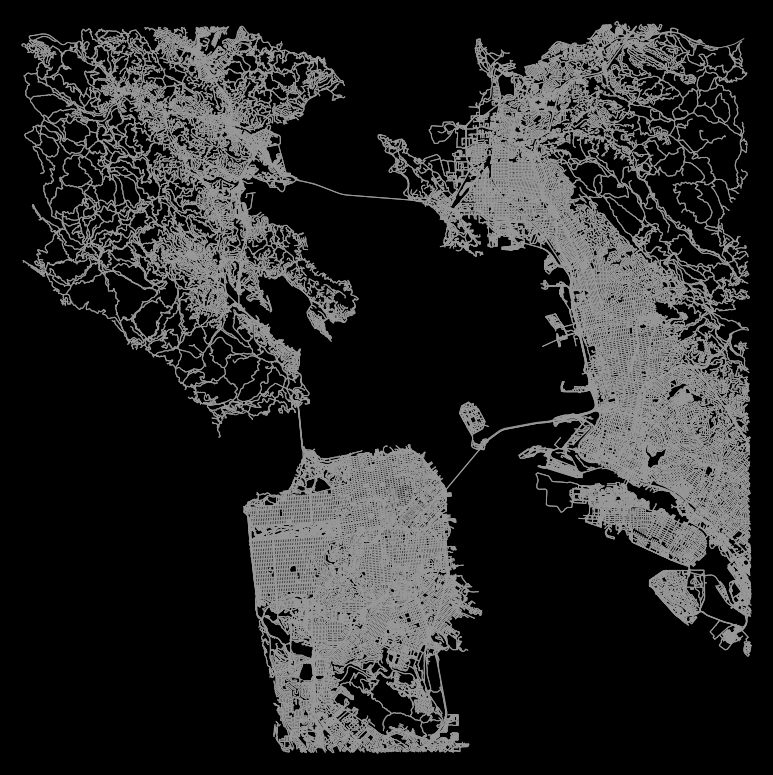

In [9]:
fig, ax = ox.plot_graph(G, equal_aspect=True,
                        node_size=0, save=True, fig_height=14, fig_width=16, use_geom=True,
                        close=False, show=False, bgcolor='k')

In [10]:
len(G.edges())

283976

In [11]:
len(G.nodes())

107593

In [12]:
ox.get_nearest_node(G, origin_point)

4918775874

In [13]:
G.nodes[4918775874]

{'y': 4176861.9958405793,
 'x': 570658.0766221767,
 'osmid': 4918775874,
 'highway': nan,
 'ref': nan,
 'lon': -122.1980833,
 'lat': 37.7363157,
 'calculated': False}

In [ ]:
missing = []
nodes = []

files = ['../1807 Page Street, San Francisco, CA.10000.routed.pkl',
           '../2010 Filbert Street, Oakland CA.10000.routed.pkl',
           '../42 Olive Avenue, Larkspur, CA.10000.routed.pkl']

for address in addresses:
    node = ox.get_nearest_node(G, origin_point)
    
    motorshed.get_transit_times(G, origin_point)
    missing_edges, missing_nodes = motorshed.find_all_routes(G, node)
    
# for fn,address in zip(files,addresses):
#     with open(fn, 'rb') as f:
#         routed, node = pickle.load(f)
#         nodes.append(node)

#         for i0, i1, key, data in tqdm(routed.edges(data=True, keys=True)):
#             try: 
#                 G.edges[i0, i1, key]['through_traffic'] += data['through_traffic']
#                 G.edges[i0, i1, key][address] += data['through_traffic']
#             except KeyError: missing.append((i0, i1))

In [ ]:
data

# Sampling

In [21]:
G_sample = G.copy()

k = len(G.edges) - 500
# sampled_nodes = random.sample(G.nodes, k)
sampled_edges = random.sample(G.edges, k)
G_sample.remove_edges_from(sampled_edges)

[(3519874727, 3519874726, 0),
 (6270715220, 6270715238, 0),
 (2308955233, 3907629289, 0)]

In [ ]:
motorshed.get_transit_times(G_sample, origin_point)

In [17]:
missing_edges, missing_nodes = motorshed.find_all_routes(G_sample, node)

  0%|          | 0/119482 [00:00<?, ?it/s]


KeyError: 'calculated'

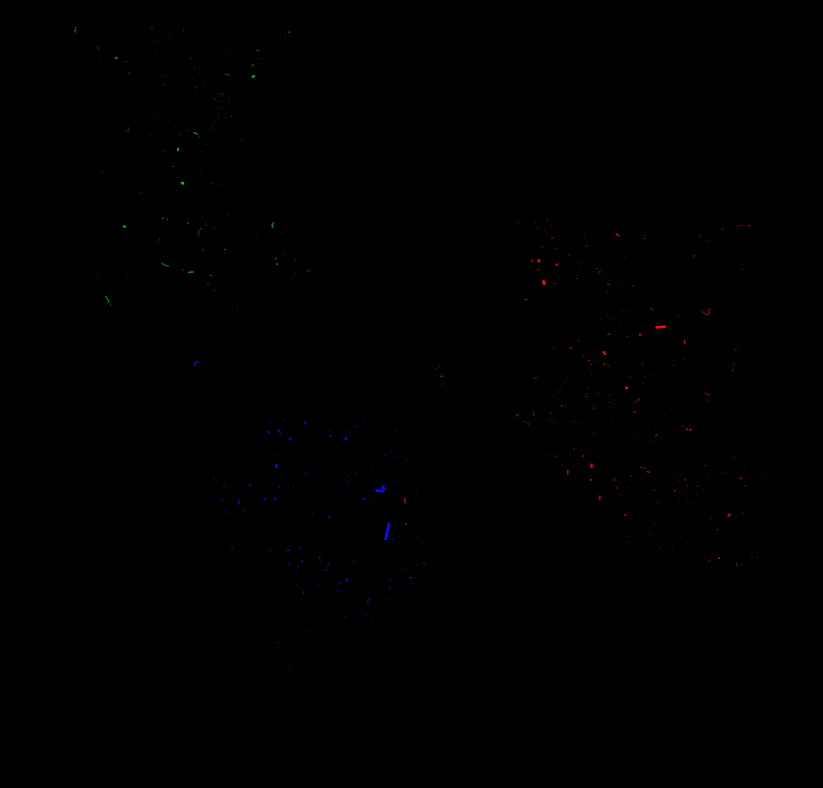

In [9]:
edge_intensity = np.log2(np.array([data['through_traffic'] for u, v, data in G_sample.edges(data=True)]))
edge_widths = (edge_intensity / edge_intensity.max()) * 3  # + 1

edge_colors = []
intensities = []
for cmap_name,address in zip(['magma','Greys','viridis'], ['filbert','olive','page']):
    edge_intensity = np.log2(np.array([data[address] for u, v, data in G_sample.edges(data=True)]))
    edge_intensity = (edge_intensity / edge_intensity.max()) * .95 + .05
    edge_intensity = (edge_intensity * 255).astype(np.uint8)

    cmap = cm.get_cmap(name=cmap_name)
    edge_colors.append(cmap(edge_intensity))
    intensities.append(edge_intensity)

edge_colors = np.stack(edge_colors)
intensities = np.stack(intensities)
# edge_colors = (edge_colors*np.expand_dims(intensities, axis=2)).mean(axis=0)
# edge_colors /= np.expand_dims(edge_colors[:,3], axis=1)

edge_colors = intensities.T / 255.

fig, ax = ox.plot_graph(G_sample, equal_aspect=True, edge_color=edge_colors, edge_linewidth=edge_widths,
                        node_size=0, save=True, fig_height=14, fig_width=16, use_geom=True,
                        close=False, show=False, bgcolor='k')

In [10]:
width_dict = dict(zip(G_sample.edges(keys=True), edge_widths.tolist()))
color_dict = dict(zip(G_sample.edges(keys=True), edge_colors.tolist()))

nx.set_edge_attributes(G_sample, width_dict, 'width')
nx.set_edge_attributes(G_sample, color_dict, 'color')

In [18]:
G_sample.edges[random.sample(G_sample.edges, 1)[0]]

{'filbert': 1,
 'geometry': <shapely.geometry.linestring.LineString at 0x15271ad588>,
 'highway': 'residential',
 'length': 242.83225124469817,
 'name': 'Lincoln Drive',
 'olive': 1,
 'oneway': False,
 'osmid': 90942400,
 'page': 1,
 'through_traffic': 1}

In [15]:
G_sample.nodes[random.sample(G_sample.nodes, 1)[0]]

{'highway': nan,
 'lat': 37.718901,
 'lon': -122.415554,
 'osmid': '4272343203',
 'ref': nan,
 'transit_time': 1139.8,
 'x': 551508.2694386477,
 'y': 4174787.9714177144}

# All edges

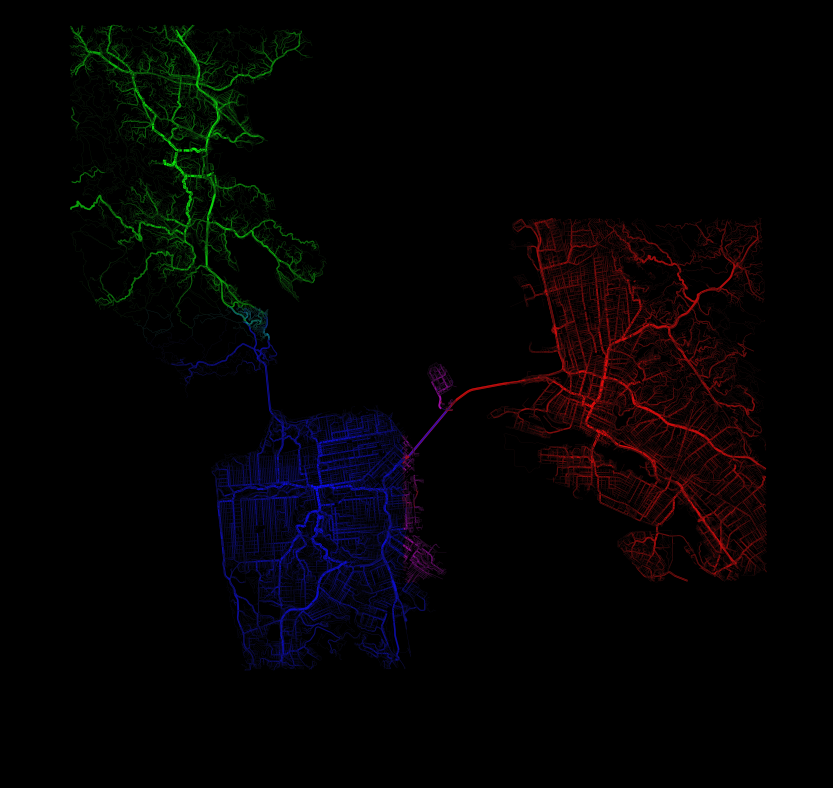

In [12]:
edge_intensity = np.log2(np.array([through_traffic for u, v, through_traffic in G.edges(data='through_traffic')]))
edge_widths = (edge_intensity / edge_intensity.max()) * 3  # + 1

edge_colors = []
intensities = []
for cmap_name,address in zip(['magma','Greys','viridis'], ['filbert','olive','page']):
    edge_intensity = np.log2(np.array([data[address] for u, v, data in G.edges(data=True)]))
    edge_intensity = (edge_intensity / edge_intensity.max()) * .95 + .05
    edge_intensity = (edge_intensity * 255).astype(np.uint8)

    cmap = cm.get_cmap(name=cmap_name)
    edge_colors.append(cmap(edge_intensity))
    intensities.append(edge_intensity)

edge_colors = np.stack(edge_colors)
intensities = np.stack(intensities)
# edge_colors = (edge_colors*np.expand_dims(intensities, axis=2)).mean(axis=0)
# edge_colors /= np.expand_dims(edge_colors[:,3], axis=1)

edge_colors = intensities.T / 255.

fig, ax = ox.plot_graph(G, equal_aspect=True, edge_color=edge_colors, edge_linewidth=edge_widths,
                        node_size=0, save=True, fig_height=14, fig_width=16, use_geom=True,
                        close=False, show=False, bgcolor='k')

In [37]:
int_colors = (edge_colors*255).astype('uint8').tolist()
hex_colors = ["#{0:02x}{1:02x}{2:02x}".format(*tuple(color)) for color in int_colors]

color_dict = dict(zip(G.edges(keys=True), hex_colors))
width_dict = dict(zip(G.edges(keys=True), edge_widths.tolist()))

nx.set_edge_attributes(G, width_dict, 'width')
nx.set_edge_attributes(G, color_dict, 'color')

In [ ]:
G.edges[random.sample(G.edges, 1)[0]]

In [39]:
import sys
sys.path.insert(0, '../')

import motorshed
from bokeh.io import export_png

In [40]:
from importlib import reload
reload(motorshed)

<module 'motorshed' from '../motorshed.py'>

In [41]:
nodes

[65346059, 5481163688, 110419941]

In [42]:
p = motorshed.make_bokeh_map(G, nodes, color_by=None)

export_png(p, filename='Tyler.png')

'/Users/octavisemonin/Dropbox/motorshed/notebooks/Tyler.png'